In [3]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from pathlib import Path

# NLP libraries
try:
    import torch
    from transformers import (
        AutoTokenizer,
        AutoModelForSequenceClassification,
        AutoModelForTokenClassification,
        pipeline,
    )
    import nltk
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
except ImportError as e:
    print(f"Missing dependency: {e}")
    print("Install with: pip install transformers torch nltk")

# Download NLTK data
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)

print("✓ Dependencies loaded successfully")

✓ Dependencies loaded successfully


## 2. Sample Traffic-Related Social Media Data

Creating synthetic social media posts for demonstration. In production, this would be collected from Twitter/X API, local news feeds, or traffic reporting platforms.


In [4]:
# Sample social media posts about traffic
sample_posts = [
    # Accidents and incidents
    "Major accident on Highway 101 near downtown exit. Traffic completely stopped! 🚗💥",
    "Car crash on Main Street blocking two lanes. Expect delays of 30+ minutes.",
    "Overturned truck on I-95 southbound. Emergency services on scene.",
    # Construction and road work
    "Road construction on Oak Avenue starting Monday. Lane closures expected for 2 weeks.",
    "Bridge repair work causing single lane traffic on River Road.",
    "New traffic lights being installed at 5th and Broadway intersection.",
    # Events impacting traffic
    "Big concert at City Arena tonight! Traffic around downtown will be crazy.",
    "Football game at the stadium - leave early to avoid the rush!",
    "Marathon running through city center tomorrow. Multiple road closures.",
    # General traffic conditions
    "Traffic flowing smoothly on the freeway this morning. Great commute!",
    "Ugh, stuck in gridlock again on the 405. This city needs better transit.",
    "Loving the new bike lanes - traffic seems lighter since they were added.",
    # Weather-related
    "Heavy rain causing slow traffic everywhere. Drive carefully!",
    "Fog advisory - visibility poor on coastal highways.",
    "Ice on roads this morning. Several fender benders reported.",
]

# Create DataFrame
df_posts = pd.DataFrame(
    {
        "post_id": range(1, len(sample_posts) + 1),
        "text": sample_posts,
        "timestamp": pd.date_range(
            start="2024-01-15 06:00", periods=len(sample_posts), freq="2H"
        ),
    }
)

print(f"Sample dataset: {len(df_posts)} posts")
df_posts.head()

Sample dataset: 15 posts


C:\Users\Muhammad Umer\AppData\Local\Temp\ipykernel_4744\3578323038.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "timestamp": pd.date_range(


,post_id,text,timestamp
0,1,Major accident on Highway 101 near downtown ex...,2024-01-15 06:00:00
1,2,Car crash on Main Street blocking two lanes. E...,2024-01-15 08:00:00
2,3,Overturned truck on I-95 southbound. Emergency...,2024-01-15 10:00:00
3,4,Road construction on Oak Avenue starting Monda...,2024-01-15 12:00:00
4,5,Bridge repair work causing single lane traffic...,2024-01-15 14:00:00


## 3. Text Preprocessing Pipeline


In [5]:
class TrafficTextPreprocessor:
    """Text preprocessing for traffic-related social media content."""

    def __init__(self):
        self.stop_words = set(stopwords.words("english"))
        # Traffic-specific terms to keep even if they're stopwords
        self.keep_words = {"no", "not", "up", "down", "out", "off", "on"}

    def clean_text(self, text: str) -> str:
        """Clean and normalize text."""
        # Lowercase
        text = text.lower()

        # Remove URLs
        text = re.sub(r"http\S+|www\S+", "", text)

        # Remove mentions and hashtags but keep the content
        text = re.sub(r"@\w+", "", text)
        text = re.sub(r"#(\w+)", r"\1", text)

        # Remove emojis but keep punctuation for sentiment
        text = re.sub(r"[^\w\s.,!?-]", "", text)

        # Normalize whitespace
        text = " ".join(text.split())

        return text.strip()

    def tokenize(self, text: str) -> list:
        """Tokenize text."""
        return word_tokenize(text)

    def preprocess(self, text: str) -> str:
        """Full preprocessing pipeline."""
        cleaned = self.clean_text(text)
        return cleaned


# Initialize preprocessor
preprocessor = TrafficTextPreprocessor()

# Apply preprocessing
df_posts["cleaned_text"] = df_posts["text"].apply(preprocessor.preprocess)

# Show example
print("Original:", df_posts["text"].iloc[0])
print("Cleaned: ", df_posts["cleaned_text"].iloc[0])

Original: Major accident on Highway 101 near downtown exit. Traffic completely stopped! 🚗💥
Cleaned:  major accident on highway 101 near downtown exit. traffic completely stopped!


## 4. Traffic Event Classification

Using a pre-trained transformer model for classifying traffic-related events.


In [6]:
# Define traffic event categories
TRAFFIC_EVENTS = {
    "accident": [
        "accident",
        "crash",
        "collision",
        "overturned",
        "wreck",
        "fender bender",
    ],
    "construction": [
        "construction",
        "roadwork",
        "repair",
        "maintenance",
        "closure",
        "lane closure",
    ],
    "event": ["concert", "game", "marathon", "parade", "festival", "stadium", "arena"],
    "weather": ["rain", "snow", "ice", "fog", "storm", "flood", "visibility"],
    "congestion": ["traffic", "gridlock", "jam", "slow", "backed up", "delay", "stuck"],
}


def classify_traffic_event(text: str) -> dict:
    """Rule-based traffic event classification."""
    text_lower = text.lower()
    detected_events = []

    for event_type, keywords in TRAFFIC_EVENTS.items():
        for keyword in keywords:
            if keyword in text_lower:
                detected_events.append(event_type)
                break

    # Determine primary event and severity
    severity = "low"
    if "accident" in detected_events:
        severity = "high"
    elif "construction" in detected_events or "event" in detected_events:
        severity = "medium"
    elif "weather" in detected_events:
        severity = "medium"

    return {
        "events": list(set(detected_events)) if detected_events else ["general"],
        "severity": severity,
        "traffic_impact": len(detected_events) > 0,
    }


# Apply classification
df_posts["event_classification"] = df_posts["cleaned_text"].apply(
    classify_traffic_event
)

# Extract for easier analysis
df_posts["events"] = df_posts["event_classification"].apply(lambda x: x["events"])
df_posts["severity"] = df_posts["event_classification"].apply(lambda x: x["severity"])
df_posts["has_traffic_impact"] = df_posts["event_classification"].apply(
    lambda x: x["traffic_impact"]
)

print("Event classification complete!")
df_posts[["text", "events", "severity"]].head(10)

Event classification complete!


,text,events,severity
0,Major accident on Highway 101 near downtown ex...,"[accident, congestion]",high
1,Car crash on Main Street blocking two lanes. E...,"[accident, congestion]",high
2,Overturned truck on I-95 southbound. Emergency...,"[weather, accident]",high
3,Road construction on Oak Avenue starting Monda...,[construction],medium
4,Bridge repair work causing single lane traffic...,"[construction, congestion]",medium
5,New traffic lights being installed at 5th and ...,[congestion],low
6,Big concert at City Arena tonight! Traffic aro...,"[event, congestion]",medium
7,Football game at the stadium - leave early to ...,[event],medium
8,Marathon running through city center tomorrow....,"[event, construction]",medium
9,Traffic flowing smoothly on the freeway this m...,[congestion],low


## 5. Sentiment Analysis

Using HuggingFace's pre-trained sentiment model to analyze traffic-related sentiment.


In [8]:
# Initialize sentiment analysis pipeline
print("Loading sentiment analysis model...")
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=-1,  # CPU, use 0 for GPU
)
print("✓ Model loaded")


def analyze_sentiment(text: str) -> dict:
    """Analyze sentiment of traffic-related text."""
    try:
        result = sentiment_analyzer(text[:512])[0]  # Truncate to max length
        return {"label": result["label"], "score": round(result["score"], 4)}
    except Exception as e:
        return {"label": "NEUTRAL", "score": 0.5}


# Apply sentiment analysis
df_posts["sentiment"] = df_posts["cleaned_text"].apply(analyze_sentiment)
df_posts["sentiment_label"] = df_posts["sentiment"].apply(lambda x: x["label"])
df_posts["sentiment_score"] = df_posts["sentiment"].apply(lambda x: x["score"])

print("\nSentiment Analysis Results:")
df_posts[["text", "sentiment_label", "sentiment_score"]].head(10)

Loading sentiment analysis model...



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


✓ Model loaded

Sentiment Analysis Results:


,text,sentiment_label,sentiment_score
0,Major accident on Highway 101 near downtown ex...,NEGATIVE,0.9983
1,Car crash on Main Street blocking two lanes. E...,NEGATIVE,0.9983
2,Overturned truck on I-95 southbound. Emergency...,NEGATIVE,0.9790
3,Road construction on Oak Avenue starting Monda...,NEGATIVE,0.9927
4,Bridge repair work causing single lane traffic...,NEGATIVE,0.9770
5,New traffic lights being installed at 5th and ...,POSITIVE,0.9620
6,Big concert at City Arena tonight! Traffic aro...,POSITIVE,0.9990
7,Football game at the stadium - leave early to ...,NEGATIVE,0.9958
8,Marathon running through city center tomorrow....,NEGATIVE,0.9976
9,Traffic flowing smoothly on the freeway this m...,POSITIVE,0.9997


## 6. Named Entity Recognition (Location Extraction)


In [9]:
# Initialize NER pipeline
print("Loading NER model...")
ner_analyzer = pipeline(
    "ner", model="dslim/bert-base-NER", aggregation_strategy="simple", device=-1
)
print("✓ NER model loaded")


def extract_locations(text: str) -> list:
    """Extract location entities from text."""
    try:
        entities = ner_analyzer(text)
        locations = [ent["word"] for ent in entities if ent["entity_group"] == "LOC"]
        return locations
    except Exception as e:
        return []


# Apply NER
df_posts["locations"] = df_posts["text"].apply(extract_locations)

print("\nLocation Extraction Results:")
df_posts[["text", "locations"]].head(10)

Loading NER model...


config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

d:\Workspace\datascience-projects\Intelligent_Urban_Traffic_Optimization\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Muhammad Umer\.cache\huggingface\hub\models--dslim--bert-base-NER. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package 

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


✓ NER model loaded

Location Extraction Results:


,text,locations
0,Major accident on Highway 101 near downtown ex...,[]
1,Car crash on Main Street blocking two lanes. E...,[Main Street]
2,Overturned truck on I-95 southbound. Emergency...,[]
3,Road construction on Oak Avenue starting Monda...,[Oak Avenue]
4,Bridge repair work causing single lane traffic...,[River Road]
5,New traffic lights being installed at 5th and ...,"[5th, Broadway]"
6,Big concert at City Arena tonight! Traffic aro...,[City Arena]
7,Football game at the stadium - leave early to ...,[]
8,Marathon running through city center tomorrow....,[]
9,Traffic flowing smoothly on the freeway this m...,[]


## 7. Traffic Impact Scoring


In [10]:
def calculate_traffic_impact_score(row) -> float:
    """Calculate overall traffic impact score (0-100)."""
    score = 0

    # Event severity contribution
    severity_scores = {"high": 40, "medium": 25, "low": 10}
    score += severity_scores.get(row["severity"], 0)

    # Negative sentiment indicates frustration (higher impact)
    if row["sentiment_label"] == "NEGATIVE":
        score += 20 * row["sentiment_score"]

    # More event types = higher complexity
    score += len(row["events"]) * 5

    # Location specificity
    if len(row["locations"]) > 0:
        score += 10

    return min(100, round(score, 2))


df_posts["impact_score"] = df_posts.apply(calculate_traffic_impact_score, axis=1)

# Sort by impact
df_sorted = df_posts.sort_values("impact_score", ascending=False)

print("\n📊 Top Traffic Impact Posts:")
df_sorted[["text", "events", "severity", "impact_score"]].head(10)


📊 Top Traffic Impact Posts:


,text,events,severity,impact_score
1,Car crash on Main Street blocking two lanes. E...,"[accident, congestion]",high,79.97
0,Major accident on Highway 101 near downtown ex...,"[accident, congestion]",high,69.97
2,Overturned truck on I-95 southbound. Emergency...,"[weather, accident]",high,69.58
14,Ice on roads this morning. Several fender bend...,"[weather, accident]",high,68.90
4,Bridge repair work causing single lane traffic...,"[construction, congestion]",medium,64.54
3,Road construction on Oak Avenue starting Monda...,[construction],medium,59.85
8,Marathon running through city center tomorrow....,"[event, construction]",medium,54.95
12,Heavy rain causing slow traffic everywhere. Dr...,"[weather, congestion]",medium,54.76
13,Fog advisory - visibility poor on coastal high...,[weather],medium,49.99
7,Football game at the stadium - leave early to ...,[event],medium,49.92


## 8. Visualization


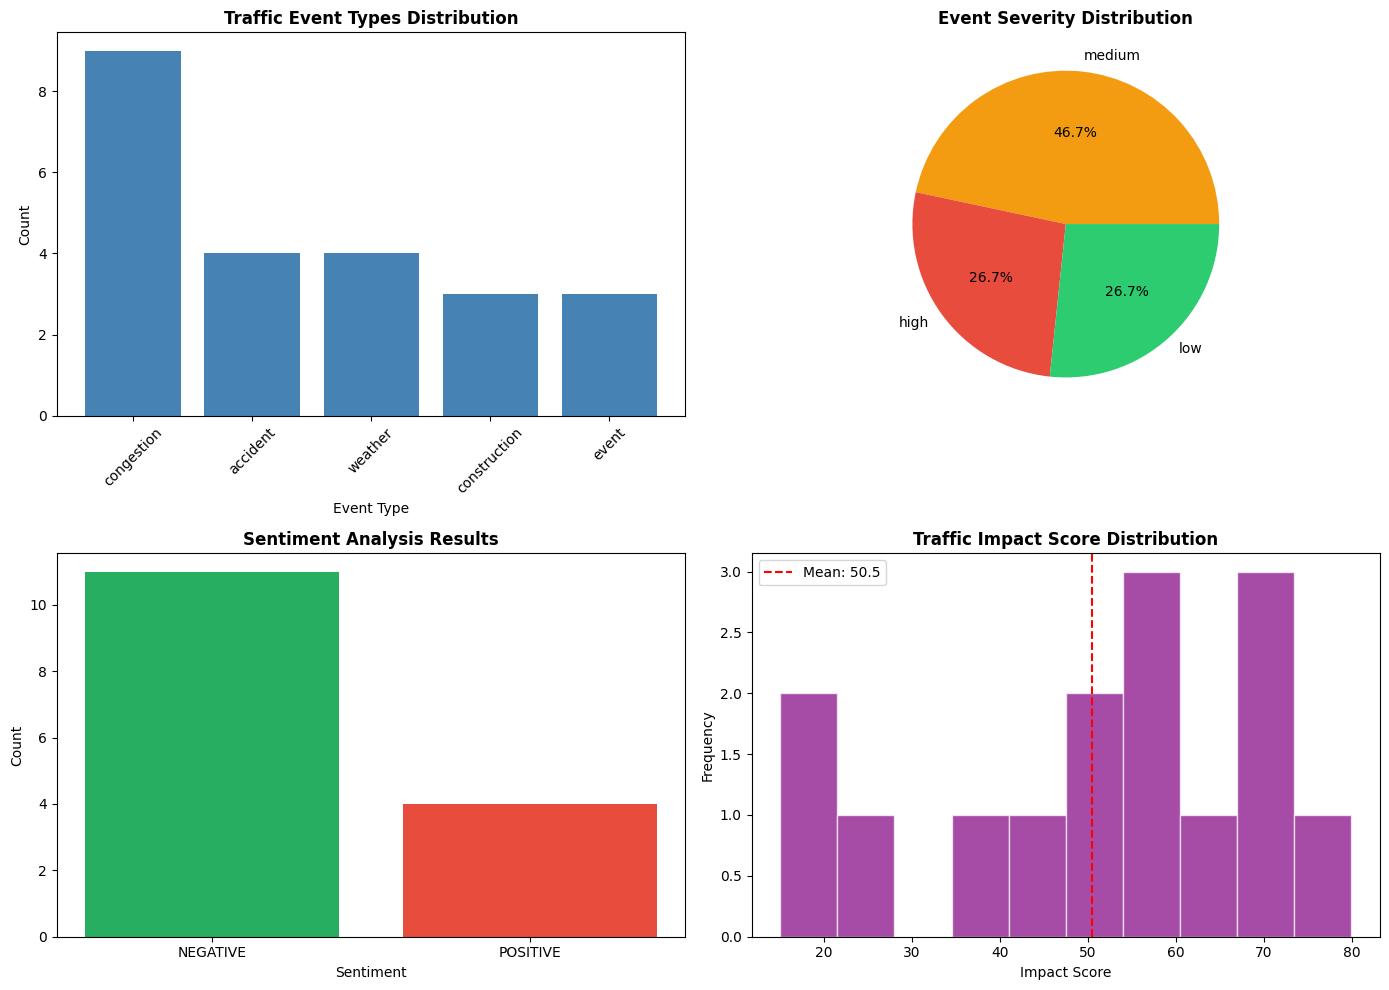


✓ Visualization saved to nlp_analysis_results.png


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Event Type Distribution
all_events = [event for events in df_posts["events"] for event in events]
event_counts = pd.Series(all_events).value_counts()
axes[0, 0].bar(event_counts.index, event_counts.values, color="steelblue")
axes[0, 0].set_title("Traffic Event Types Distribution", fontsize=12, fontweight="bold")
axes[0, 0].set_xlabel("Event Type")
axes[0, 0].set_ylabel("Count")
axes[0, 0].tick_params(axis="x", rotation=45)

# 2. Severity Distribution
severity_counts = df_posts["severity"].value_counts()
colors = {"high": "#e74c3c", "medium": "#f39c12", "low": "#2ecc71"}
axes[0, 1].pie(
    severity_counts.values,
    labels=severity_counts.index,
    autopct="%1.1f%%",
    colors=[colors[s] for s in severity_counts.index],
)
axes[0, 1].set_title("Event Severity Distribution", fontsize=12, fontweight="bold")

# 3. Sentiment Distribution
sentiment_counts = df_posts["sentiment_label"].value_counts()
axes[1, 0].bar(
    sentiment_counts.index, sentiment_counts.values, color=["#27ae60", "#e74c3c"]
)
axes[1, 0].set_title("Sentiment Analysis Results", fontsize=12, fontweight="bold")
axes[1, 0].set_xlabel("Sentiment")
axes[1, 0].set_ylabel("Count")

# 4. Impact Score Distribution
axes[1, 1].hist(
    df_posts["impact_score"], bins=10, color="purple", edgecolor="white", alpha=0.7
)
axes[1, 1].axvline(
    df_posts["impact_score"].mean(),
    color="red",
    linestyle="--",
    label=f'Mean: {df_posts["impact_score"].mean():.1f}',
)
axes[1, 1].set_title(
    "Traffic Impact Score Distribution", fontsize=12, fontweight="bold"
)
axes[1, 1].set_xlabel("Impact Score")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].legend()

plt.tight_layout()
plt.savefig("nlp_analysis_results.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n✓ Visualization saved to nlp_analysis_results.png")

## 9. NLP Wrapper Class for Integration


In [12]:
class TrafficNLPAnalyzer:
    """
    Complete NLP analyzer for traffic-related social media content.
    This class is used by the integration layer wrapper.
    """

    def __init__(self, device: int = -1):
        """
        Initialize the NLP analyzer.

        Args:
            device: -1 for CPU, 0+ for GPU
        """
        self.device = device
        self.preprocessor = TrafficTextPreprocessor()
        self._sentiment_model = None
        self._ner_model = None

    def _load_models(self):
        """Lazy load NLP models."""
        if self._sentiment_model is None:
            self._sentiment_model = pipeline(
                "sentiment-analysis",
                model="distilbert-base-uncased-finetuned-sst-2-english",
                device=self.device,
            )
        if self._ner_model is None:
            self._ner_model = pipeline(
                "ner",
                model="dslim/bert-base-NER",
                aggregation_strategy="simple",
                device=self.device,
            )

    def analyze(self, text: str) -> dict:
        """
        Full analysis of a social media post.

        Returns:
            Dictionary with event detection, sentiment, locations, and impact score.
        """
        self._load_models()

        # Preprocess
        cleaned_text = self.preprocessor.preprocess(text)

        # Event classification
        event_info = classify_traffic_event(cleaned_text)

        # Sentiment
        sentiment = analyze_sentiment(cleaned_text)

        # Locations
        locations = extract_locations(text)

        # Calculate impact score
        impact_score = self._calculate_impact(event_info, sentiment, locations)

        return {
            "original_text": text,
            "cleaned_text": cleaned_text,
            "events": event_info["events"],
            "severity": event_info["severity"],
            "sentiment": sentiment,
            "locations": locations,
            "impact_score": impact_score,
            "has_traffic_impact": event_info["traffic_impact"],
        }

    def _calculate_impact(self, event_info, sentiment, locations) -> float:
        """Calculate traffic impact score."""
        score = 0
        severity_scores = {"high": 40, "medium": 25, "low": 10}
        score += severity_scores.get(event_info["severity"], 0)

        if sentiment["label"] == "NEGATIVE":
            score += 20 * sentiment["score"]

        score += len(event_info["events"]) * 5

        if len(locations) > 0:
            score += 10

        return min(100, round(score, 2))

    def analyze_batch(self, texts: list) -> list:
        """Analyze multiple posts."""
        return [self.analyze(text) for text in texts]


# Test the analyzer
analyzer = TrafficNLPAnalyzer()
test_result = analyzer.analyze(
    "Major accident on Highway 101! Traffic is completely stopped."
)
print("\nTest Analysis Result:")
print(json.dumps(test_result, indent=2))

Device set to use cpu
Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu



Test Analysis Result:
{
  "original_text": "Major accident on Highway 101! Traffic is completely stopped.",
  "cleaned_text": "major accident on highway 101! traffic is completely stopped.",
  "events": [
    "accident",
    "congestion"
  ],
  "severity": "high",
  "sentiment": {
    "label": "NEGATIVE",
    "score": 0.9992
  },
  "locations": [],
  "impact_score": 69.98,
  "has_traffic_impact": true
}


## 10. Export Results and Summary


In [13]:
# Export analyzed data
output_df = df_posts[
    [
        "post_id",
        "text",
        "events",
        "severity",
        "sentiment_label",
        "sentiment_score",
        "locations",
        "impact_score",
    ]
]
output_df.to_csv("nlp_analysis_results.csv", index=False)
print("✓ Results exported to nlp_analysis_results.csv")

# Summary statistics
print("\n" + "=" * 60)
print("📊 NLP ANALYSIS SUMMARY")
print("=" * 60)
print(f"Total posts analyzed: {len(df_posts)}")
print(f"Posts with traffic impact: {df_posts['has_traffic_impact'].sum()}")
print(f"High severity events: {(df_posts['severity'] == 'high').sum()}")
print(f"Average impact score: {df_posts['impact_score'].mean():.2f}")
print(f"Negative sentiment posts: {(df_posts['sentiment_label'] == 'NEGATIVE').sum()}")
print(f"Posts with location data: {(df_posts['locations'].apply(len) > 0).sum()}")
print("=" * 60)

✓ Results exported to nlp_analysis_results.csv

📊 NLP ANALYSIS SUMMARY
Total posts analyzed: 15
Posts with traffic impact: 15
High severity events: 4
Average impact score: 50.49
Negative sentiment posts: 11
Posts with location data: 5


## 11. Integration with Traffic Optimization Pipeline

The NLP module integrates with the main traffic optimization system to provide:

1. **Early Warning System**: Detect accidents and events before sensor data shows impact
2. **Context Enhancement**: Add social media context to anomaly detection
3. **Demand Forecasting**: Predict traffic surges from event announcements
4. **Signal Optimization**: Adjust RL recommendations based on real-time social signals


In [14]:
print("\n✅ Module 6: NLP Social Media Analysis - Complete!")
print("\nThis module can be integrated via:")
print("  from integration.wrappers.nlp_wrapper import NLPWrapper")
print("  nlp = NLPWrapper()")
print("  result = nlp.analyze_text('Traffic alert text...')")


✅ Module 6: NLP Social Media Analysis - Complete!

This module can be integrated via:
  from integration.wrappers.nlp_wrapper import NLPWrapper
  nlp = NLPWrapper()
  result = nlp.analyze_text('Traffic alert text...')
